# Survival Analysis

Survival analysis (via Keplan Meier) calculates the probability of surviving beyond specific time points (here, each age). 
Here, survival refers to the absence of Alzheimer's. We see how several Risk Factors affect the onset age of Alzheimer's.  
For each time point, the function considers the number of individuals who experience the event of interest (Diagnosis=1) and the number still at risk (Diagnosis=0). 
The survival probability is updated at each time point, it is the proportion of individuals who have 'survived' (stayed healthy) up to that point. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas as pd
from scipy.stats import chi2

import data_reader
data = data_reader.get_data_dict('./data/alzheimers_disease_data.csv')

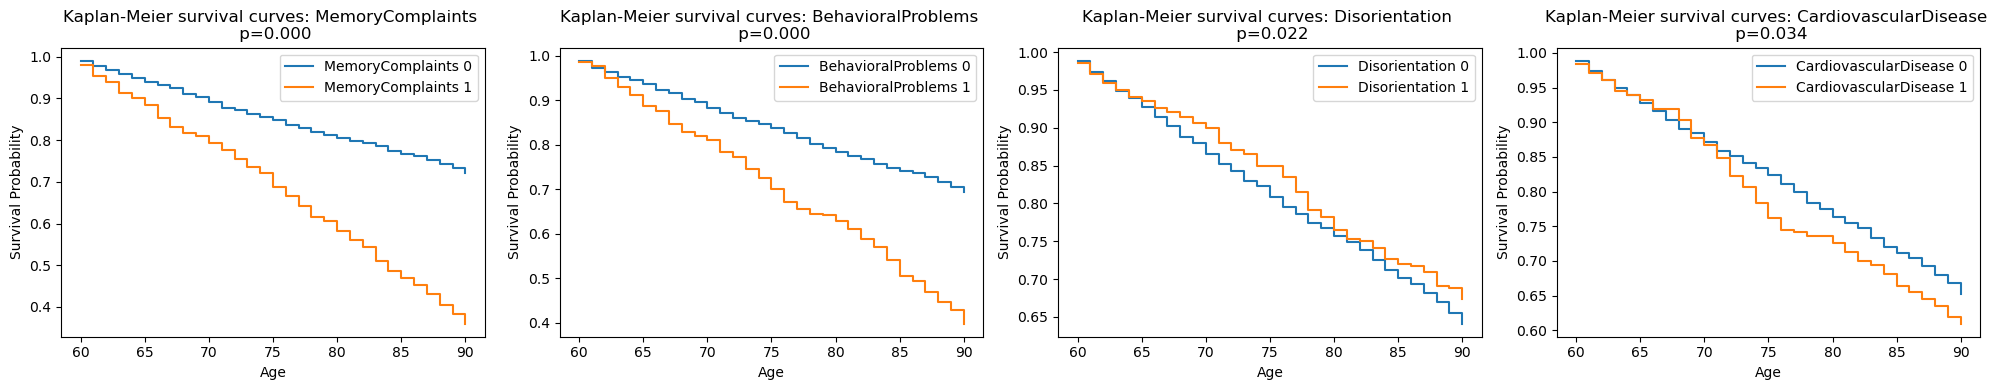

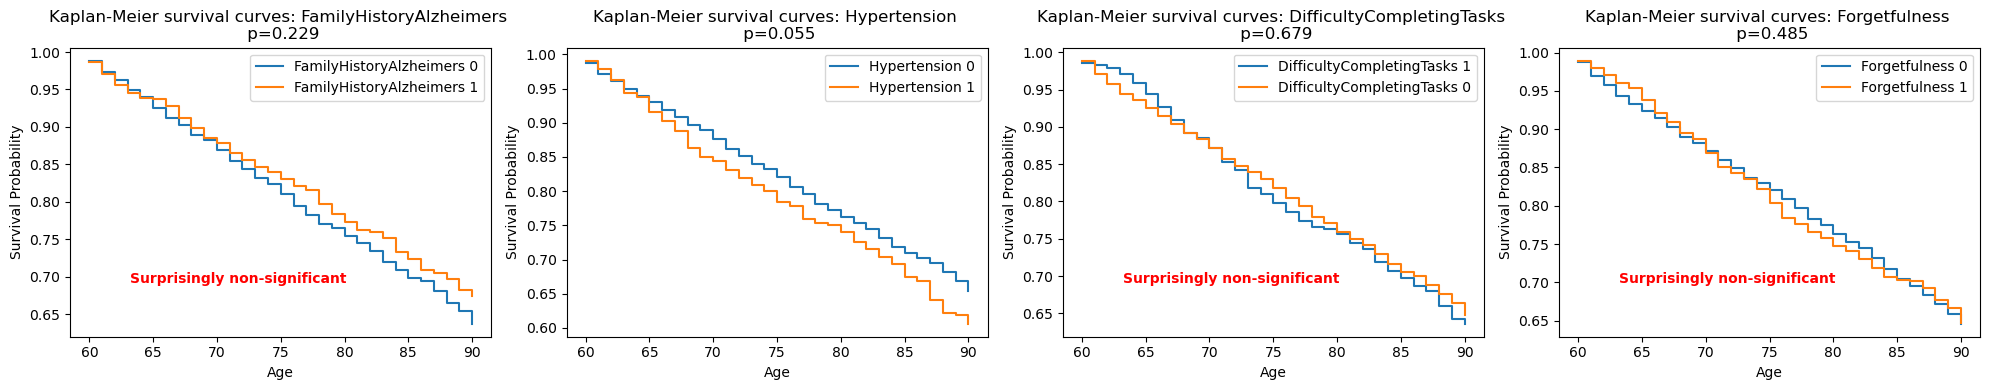


continuous variables, manually categorised:



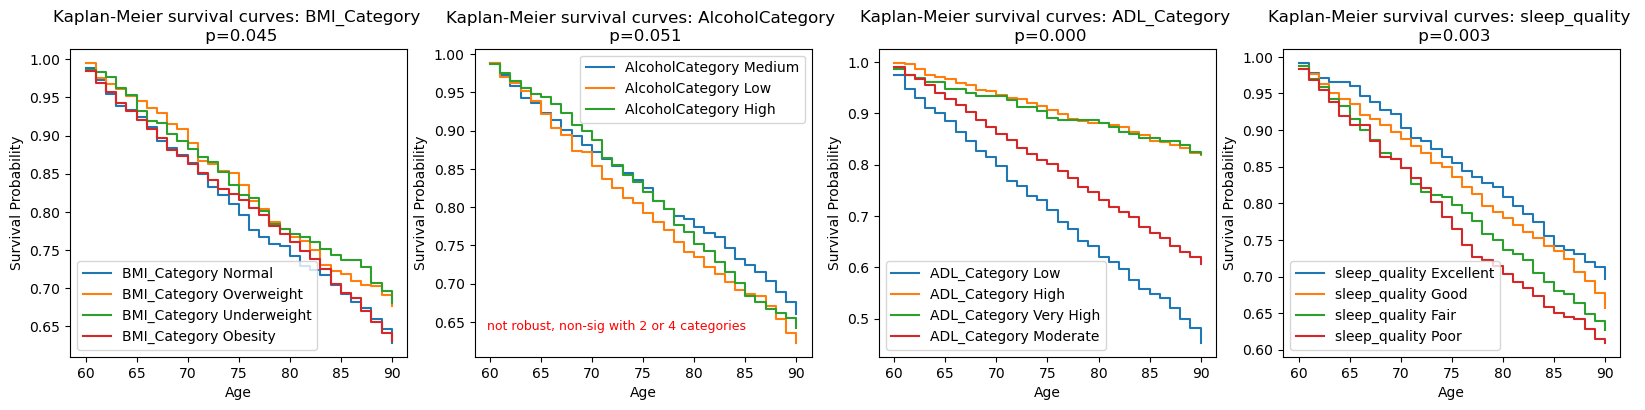

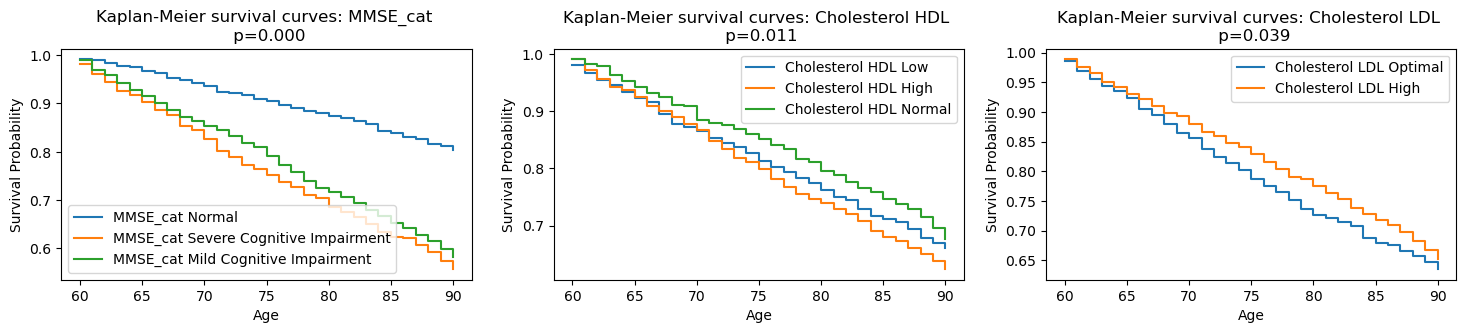

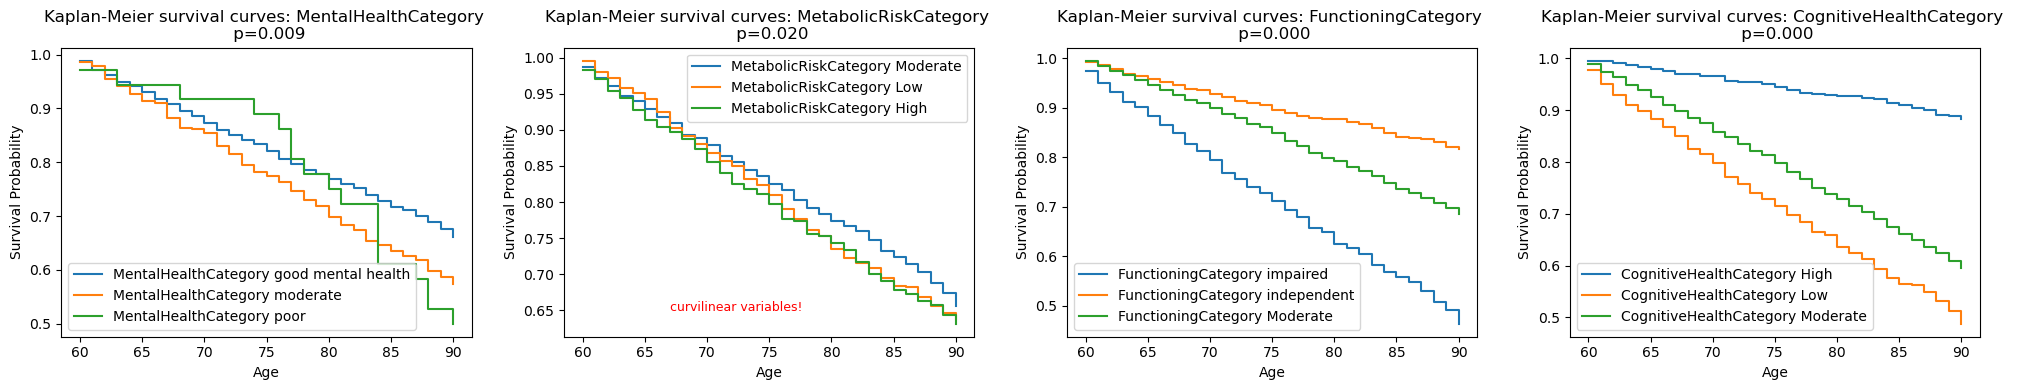

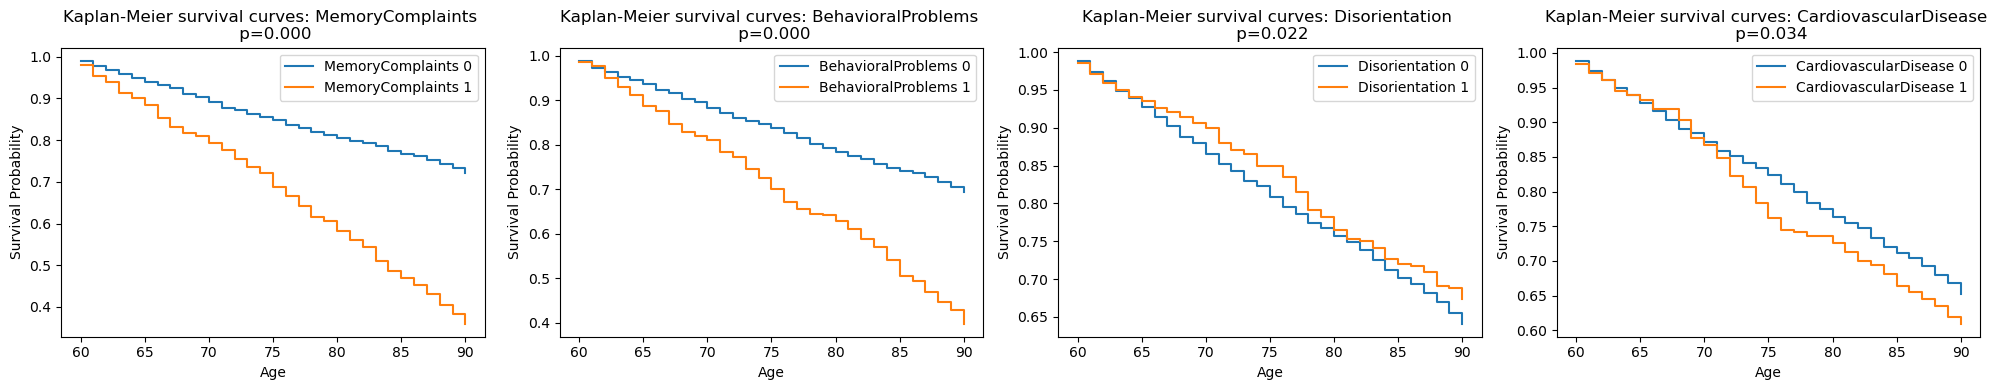

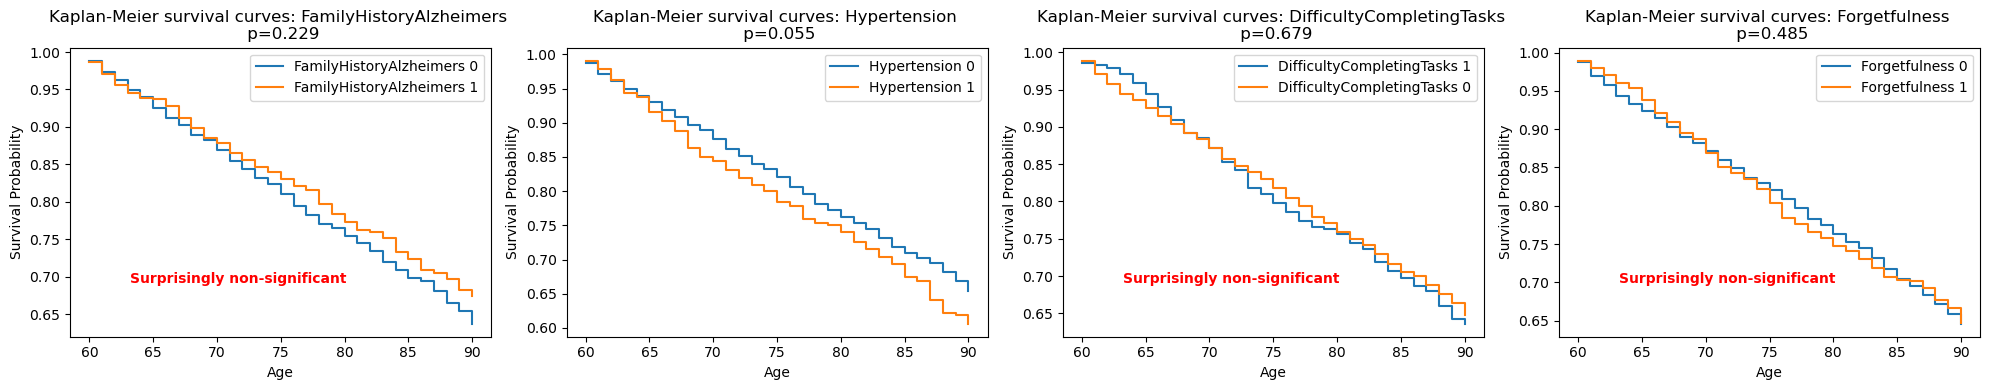


continuous variables, manually categorised:


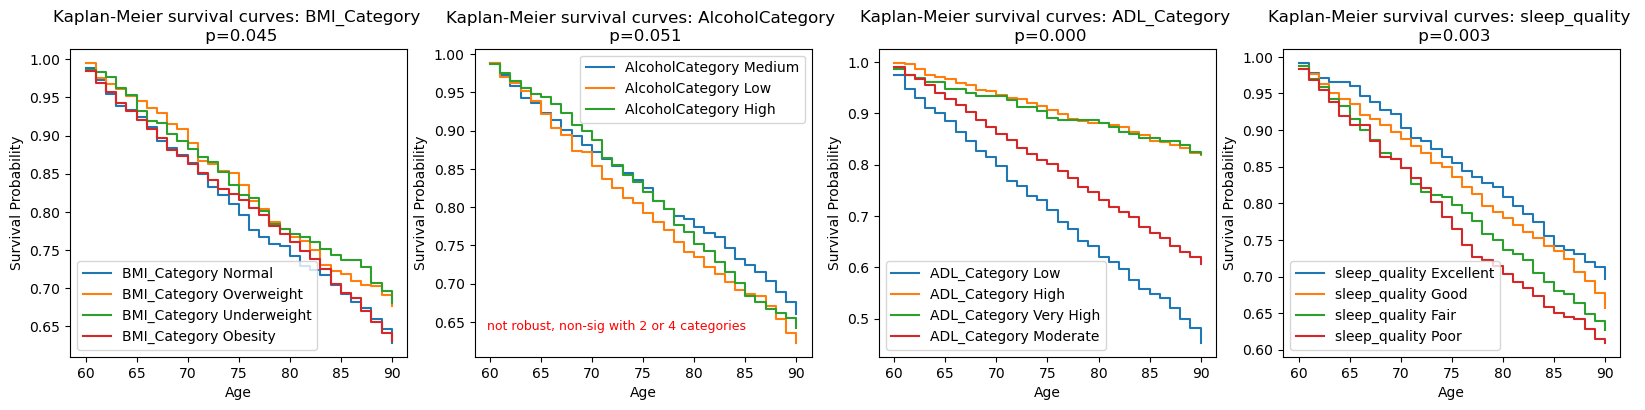

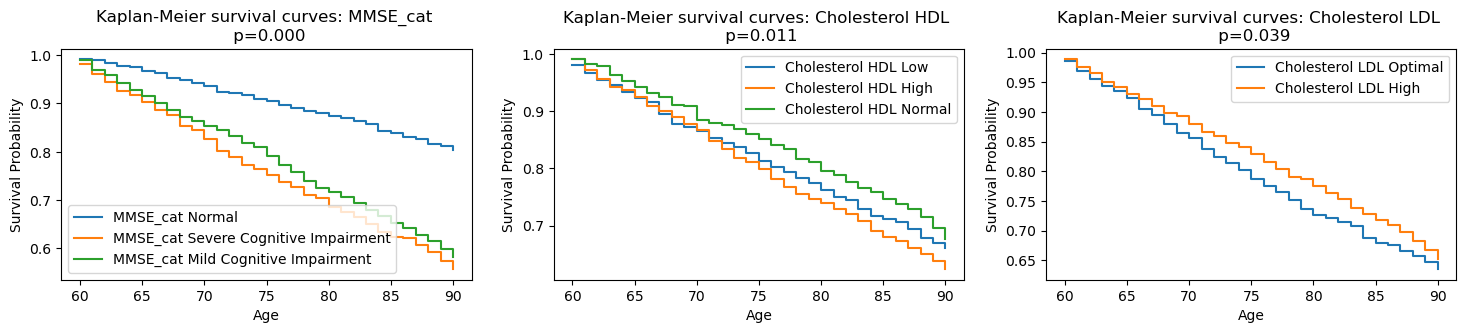

In [2]:
def kaplan_meier_estimator(df, time_col, event_col, group_col):

    '''
    This function calculates the Kaplan-Meier survival curves for each category in a categorical variable.
    '''

    # Create an empty dictionary to store Kaplan-Meier estimates per group
    km_data = {}

    # loop over each unique value (group) in the categorical variable
    for group in df[group_col].unique():

        # filter the data for the current group
        group_data = df[df[group_col] == group]

        # Extract and sort unique time points for this group
        times = sorted(group_data[time_col].unique())

        # total number of observations in the group
        n = len(group_data)

        # Initialise an empty list to store the survival probability estimates
        km_estimates = []

        # Iterate over each unique time point (i.e. each age)
        for t in times:

            # count the number of events (diagnoses) at the current time point
            d = sum((group_data[time_col] == t) & (group_data[event_col] == 1))

            # subtract to get those with diagnosis=0
            n -= d

            # store the survival probability at the current time point
            km_estimates.append((t, n / len(group_data)))

        # store the Kaplan-Meier estimates for the current group in the aforementioned dictionary
        km_data[group] = km_estimates

    return km_data


'''
The log-rank test determines whether survival curves for different groups (e.g. difference races in the variable 'Race') are statistically different. 
It compares observed and expected event counts at each time point across groups. 
Expected values are based on the overall event distribution, assuming no group differences. 
The test aggregates these differences into a chi-square statistic, quantifying how much observed data deviate from the null hypothesis (no difference between groups). 
'''

def log_rank_test(df, time_col, event_col, group_col):
    '''
    this function performs the log-rank test for comparing survival curves
    '''
    # Get the unique groups and sort the unique event times (ages)
    groups = df[group_col].unique()
    event_times = df[time_col].unique()
    event_times.sort()

    # Initialise dictionaries to store observed & expected events and variances (to account for sample size) for each group
    observed = {group: [] for group in groups}
    expected = {group: [] for group in groups}
    var = {group: [] for group in groups}

    # loop over each unique event time
    for t in event_times:

        # Calculate the number of subjects at risk (no diagnosis) at the current time point for each group
        at_risk = {group: len(df[(df[time_col] >= t) & (df[group_col] == group)]) for group in groups}

        # Calculate the number of events (diagnoses) at the current time point for each group
        events = {group: len(df[(df[time_col] == t) & (df[event_col] == 1) & (df[group_col] == group)]) for group in groups}
       
        # total the above 
        total_at_risk = sum(at_risk.values())
        total_events = sum(events.values())

        # loop over each group to calculate observed, expected, and variance
        for group in groups:

            # observed events for the current group and time point
            observed[group].append(events[group])

            # expected number of events
            expected[group].append(at_risk[group] * total_events / total_at_risk)

            # variance for the current group
            var[group].append(at_risk[group] * (total_at_risk - at_risk[group]) * total_events * (total_at_risk - total_events) / (total_at_risk ** 2 * (total_at_risk - 1)))

    # Sum up observed, expected, and variance values for each group
    observed = {group: np.sum(observed[group]) for group in groups}
    expected = {group: np.sum(expected[group]) for group in groups}
    var = {group: np.sum(var[group]) for group in groups}

    # chi-square statistic and p value 
    chi_square = np.sum([(observed[group] - expected[group]) ** 2 / var[group] for group in groups])
    p = chi2.sf(chi_square, df=len(groups) - 1)

    return chi_square, p

def plot_kaplan_meier(df, time_col, event_col, group_col, ax):

    # Compute Kaplan-Meier estimates for each group
    km_data = kaplan_meier_estimator(df, time_col, event_col, group_col)
    # Perform the log-rank test to compare survival curves
    chi_square, p = log_rank_test(df, time_col, event_col, group_col)
    
    # Plot Kaplan-Meier curves for each group
    for group in km_data:

        # Extract time points and survival probabilities for the current group
        times, estimates = zip(*km_data[group])

        # Plot the step function representing the Kaplan-Meier curve
        ax.step(times, estimates, where='post', label=f'{group_col} {group}')

    ax.set_xlabel('Age')
    ax.set_ylabel('Survival Probability')
    ax.set_title(f'Kaplan-Meier survival curves: {group_col} \n p={p:.3f}')
    ax.legend()

df = pd.DataFrame({key: value for key, value in data.items() if key != 'DoctorInCharge'})

fig, axes = plt.subplots(1, 4, figsize=(20, 4))
plot_kaplan_meier(df, 'Age', 'Diagnosis', 'MemoryComplaints', axes[0])
plot_kaplan_meier(df, 'Age', 'Diagnosis', 'BehavioralProblems', axes[1])
plot_kaplan_meier(df, 'Age', 'Diagnosis', 'Disorientation', axes[2])
plot_kaplan_meier(df, 'Age', 'Diagnosis', 'CardiovascularDisease', axes[3])
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 4, figsize=(20, 4))
plot_kaplan_meier(df, 'Age', 'Diagnosis', 'FamilyHistoryAlzheimers', axes[0])
axes[0].text(0.4, 0.2, 'Surprisingly non-significant', transform=axes[0].transAxes, ha='center', va='center', fontsize=10, color='red', fontweight='bold')
plot_kaplan_meier(df, 'Age', 'Diagnosis', 'Hypertension', axes[1])
plot_kaplan_meier(df, 'Age', 'Diagnosis', 'DifficultyCompletingTasks', axes[2])
axes[2].text(0.4, 0.2, 'Surprisingly non-significant', transform=axes[2].transAxes, ha='center', va='center', fontsize=10, color='red', fontweight='bold')
plot_kaplan_meier(df, 'Age', 'Diagnosis', 'Forgetfulness', axes[3])
axes[3].text(0.4, 0.2, 'Surprisingly non-significant', transform=axes[3].transAxes, ha='center', va='center', fontsize=10, color='red', fontweight='bold')
plt.tight_layout()
plt.show()

print()
print('continuous variables, manually categorised:')
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

# BMI 
df['BMI_Category'] = pd.cut(df['BMI'], bins=[0, 18.5, 25, 30, np.inf], labels=['Underweight', 'Normal', 'Overweight', 'Obesity'], right=False)
plot_kaplan_meier(df, 'Age', 'Diagnosis', 'BMI_Category', axes[0])

# ALCOHOL 
# not robust - non-significant with 2 or 4 categories 
df['AlcoholCategory'] = pd.qcut(df['AlcoholConsumption'], q=[0, 0.25, 0.75, 1.0], labels=['Low', 'Medium', 'High'])
plot_kaplan_meier(df, 'Age', 'Diagnosis', 'AlcoholCategory', axes[1])
axes[1].text(0.42, 0.1, 'not robust, non-sig with 2 or 4 categories', transform=axes[1].transAxes, ha='center', va='center', fontsize=9, color='red')

# ADL (acitivities of daily living e.g. self-grooming, feeding oneself)
df['ADL_Category'] = pd.cut(df['ADL'], bins=[0, 3, 6, 9, 10], labels=['Low', 'Moderate', 'High', 'Very High'], include_lowest=True)
plot_kaplan_meier(df, 'Age', 'Diagnosis', 'ADL_Category', axes[2])

# SLEEP QUALITY
df['sleep_quality'] = pd.cut(df['SleepQuality'], bins=[0, 5, 7, 9, np.inf], labels=['Poor', 'Fair', 'Good', 'Excellent'], right=False)
plot_kaplan_meier(df, 'Age', 'Diagnosis', 'sleep_quality', axes[3])

fig, axes = plt.subplots(1, 3, figsize=(18, 3))
# MMSE
df['MMSE_cat'] = pd.cut(df['MMSE'], bins=[0, 10, 20, 30], labels=['Severe Cognitive Impairment', 'Mild Cognitive Impairment', 'Normal'], right=False)
plot_kaplan_meier(df, 'Age', 'Diagnosis', 'MMSE_cat', axes[0])

# Cholesterol HDL
df['Cholesterol HDL'] = pd.cut(df['CholesterolHDL'], bins=[0, 40, 60, np.inf], labels=['Low', 'Normal', 'High'], right=False)
plot_kaplan_meier(df, 'Age', 'Diagnosis', 'Cholesterol HDL', axes[1])

# Cholesterol LDL
df['Cholesterol LDL'] = pd.cut(df['CholesterolLDL'], bins=[0, 100, 200], labels=['Optimal', 'High'], right=False)
plot_kaplan_meier(df, 'Age', 'Diagnosis', 'Cholesterol LDL', axes[2])

print()

# COMPOSITE SCORES

fig, axes = plt.subplots(1, 4, figsize=(20, 4))

df['MentalHealthScore'] = (df['Depression'] + df['BehavioralProblems'] + df['Confusion'] + df['Disorientation']) / 4
df['MentalHealthScore'] = (df['MentalHealthScore'] - df['MentalHealthScore'].min()) / (df['MentalHealthScore'].max() - df['MentalHealthScore'].min())                     
df['MentalHealthCategory'] = pd.cut(df['MentalHealthScore'], bins=[-0.01, 0.33, 0.66, 1.01], labels=['good mental health', 'moderate', 'poor'])

df['MetabolicRiskScore'] = (df['BMI'] + df['CholesterolTotal'] + df['CholesterolTriglycerides'] + df['SystolicBP'] + df['DiastolicBP']) / 5                                                
df['MetabolicRiskScore'] = (df['MetabolicRiskScore'] - df['MetabolicRiskScore'].min()) / (df['MetabolicRiskScore'].max() - df['MetabolicRiskScore'].min())                
df['MetabolicRiskCategory'] = pd.cut(df['MetabolicRiskScore'], bins=[-0.01, 0.33, 0.66, 1.01], labels=['Low', 'Moderate', 'High']) 

df['FunctioningScore'] = (df['ADL'] + df['DifficultyCompletingTasks'] + df['Forgetfulness'] + df['Disorientation']) / 4
df['FunctioningScore'] = (df['FunctioningScore'] - df['FunctioningScore'].min()) / (df['FunctioningScore'].max() - df['FunctioningScore'].min())
df['FunctioningCategory'] = pd.cut(df['FunctioningScore'], bins=[-0.01, 0.33, 0.66, 1.01], labels=['impaired', 'Moderate', 'independent'])

df['CognitiveHealthScore'] = (df['MMSE'] + df['FunctionalAssessment'] + df['MemoryComplaints']) / 3
df['CognitiveHealthScore'] = (df['CognitiveHealthScore'] - df['CognitiveHealthScore'].min()) / (df['CognitiveHealthScore'].max() - df['CognitiveHealthScore'].min())
df['CognitiveHealthCategory'] = pd.cut(df['CognitiveHealthScore'], bins=[-float('inf'), 0.33, 0.66, float('inf')], labels=['Low', 'Moderate', 'High'])

plot_kaplan_meier(df, 'Age', 'Diagnosis', 'MentalHealthCategory', axes[0])
plot_kaplan_meier(df, 'Age', 'Diagnosis', 'MetabolicRiskCategory', axes[1])
axes[1].text(0.42, 0.1, 'curvilinear variables!', transform=axes[1].transAxes, ha='center', va='center', fontsize=9, color='red')
plot_kaplan_meier(df, 'Age', 'Diagnosis', 'FunctioningCategory', axes[2])
plot_kaplan_meier(df, 'Age', 'Diagnosis', 'CognitiveHealthCategory', axes[3])
plt.tight_layout()
plt.show()



fig, axes = plt.subplots(1, 4, figsize=(20, 4))
plot_kaplan_meier(df, 'Age', 'Diagnosis', 'MemoryComplaints', axes[0])
plot_kaplan_meier(df, 'Age', 'Diagnosis', 'BehavioralProblems', axes[1])
plot_kaplan_meier(df, 'Age', 'Diagnosis', 'Disorientation', axes[2])
plot_kaplan_meier(df, 'Age', 'Diagnosis', 'CardiovascularDisease', axes[3])
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 4, figsize=(20, 4))
plot_kaplan_meier(df, 'Age', 'Diagnosis', 'FamilyHistoryAlzheimers', axes[0])
axes[0].text(0.4, 0.2, 'Surprisingly non-significant', transform=axes[0].transAxes, ha='center', va='center', fontsize=10, color='red', fontweight='bold')
plot_kaplan_meier(df, 'Age', 'Diagnosis', 'Hypertension', axes[1])
plot_kaplan_meier(df, 'Age', 'Diagnosis', 'DifficultyCompletingTasks', axes[2])
axes[2].text(0.4, 0.2, 'Surprisingly non-significant', transform=axes[2].transAxes, ha='center', va='center', fontsize=10, color='red', fontweight='bold')
plot_kaplan_meier(df, 'Age', 'Diagnosis', 'Forgetfulness', axes[3])
axes[3].text(0.4, 0.2, 'Surprisingly non-significant', transform=axes[3].transAxes, ha='center', va='center', fontsize=10, color='red', fontweight='bold')
plt.tight_layout()
plt.show()

print()
print('continuous variables, manually categorised:')
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

# BMI
df['BMI_Category'] = pd.cut(df['BMI'], bins=[0, 18.5, 25, 30, np.inf], labels=['Underweight', 'Normal', 'Overweight', 'Obesity'], right=False)
plot_kaplan_meier(df, 'Age', 'Diagnosis', 'BMI_Category', axes[0])

# ALCOHOL
# not robust - non-significant with 2 or 4 categories 
df['AlcoholCategory'] = pd.qcut(df['AlcoholConsumption'], q=[0, 0.25, 0.75, 1.0], labels=['Low', 'Medium', 'High'])
plot_kaplan_meier(df, 'Age', 'Diagnosis', 'AlcoholCategory', axes[1])
axes[1].text(0.42, 0.1, 'not robust, non-sig with 2 or 4 categories', transform=axes[1].transAxes, ha='center', va='center', fontsize=9, color='red')

# ADL (acitivities of daily living e.g. self-grooming, feeding oneself)
df['ADL_Category'] = pd.cut(df['ADL'], bins=[0, 3, 6, 9, 10], labels=['Low', 'Moderate', 'High', 'Very High'], include_lowest=True)
plot_kaplan_meier(df, 'Age', 'Diagnosis', 'ADL_Category', axes[2])

# SLEEP QUALITY
df['sleep_quality'] = pd.cut(df['SleepQuality'], bins=[0, 5, 7, 9, np.inf], labels=['Poor', 'Fair', 'Good', 'Excellent'], right=False)
plot_kaplan_meier(df, 'Age', 'Diagnosis', 'sleep_quality', axes[3])

fig, axes = plt.subplots(1, 3, figsize=(18, 3))
# MMSE
df['MMSE_cat'] = pd.cut(df['MMSE'], bins=[0, 10, 20, 30], labels=['Severe Cognitive Impairment', 'Mild Cognitive Impairment', 'Normal'], right=False)
plot_kaplan_meier(df, 'Age', 'Diagnosis', 'MMSE_cat', axes[0])

# Cholesterol HDL
df['Cholesterol HDL'] = pd.cut(df['CholesterolHDL'], bins=[0, 40, 60, np.inf], labels=['Low', 'Normal', 'High'], right=False)
plot_kaplan_meier(df, 'Age', 'Diagnosis', 'Cholesterol HDL', axes[1])

# Cholesterol LDL
df['Cholesterol LDL'] = pd.cut(df['CholesterolLDL'], bins=[0, 100, 200], labels=['Optimal', 'High'], right=False)
plot_kaplan_meier(df, 'Age', 'Diagnosis', 'Cholesterol LDL', axes[2])